In [1]:
# %%
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt 
import ipywidgets as widgets
import pandas as pd
from scipy.stats import nbinom
from GCRsim_v02f import CosmicRaySimulation

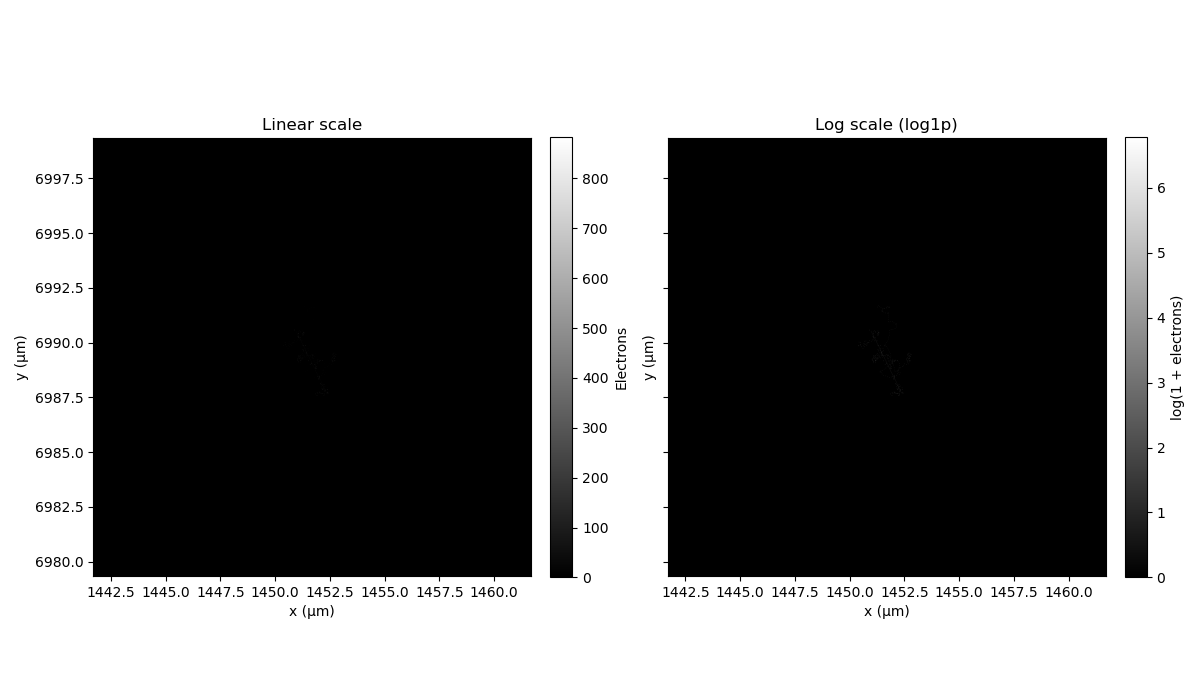

In [2]:

# ---- User Settings ----
csvfile = '202506242308_energy_loss_log.csv'
pixel_size = 10.0         # µm
grid_pixels = 2
window_size = grid_pixels * pixel_size  # 20 µm
bin_size = 0.01           # µm
nbins = int(window_size / bin_size)     # 2000
chunksize = 100_000

def electron_conversion(dE, f_eff=2.71, w=2.509):
    if dE <= 0:
        return 0
    dE = dE*1e6 # changing MeV to eV
    mu_nb = dE / w
    p = 1.0 / f_eff
    if not (0 < p < 1):
        return 0
    r = mu_nb * (p / (1.0 - p))
    if r <= 0:
        return 0
    return nbinom(r, p).rvs()

# Step 1: Find the first primary PID in the file
primary_pid = None
for chunk in pd.read_csv(csvfile, sep=',', chunksize=1):
    primary_pid = chunk['PID'].iloc[0]
    break

# Step 2: Collect all events for this primary (and its delta rays) as discrete electrons
x_electrons, y_electrons = [], []
x_events, y_events = [], []

for chunk in pd.read_csv(csvfile, sep=',', chunksize=chunksize):
    pids = chunk['PID'].to_numpy()
    xs = chunk['x'].to_numpy()
    ys = chunk['y'].to_numpy()
    dEs = chunk['dE'].to_numpy()
    parent_pids = np.array([CosmicRaySimulation.get_parent_pid(pid) for pid in pids])
    mask = (parent_pids == primary_pid)
    xs_sel = xs[mask]
    ys_sel = ys[mask]
    dEs_sel = dEs[mask]

    for x, y, dE in zip(xs_sel, ys_sel, dEs_sel):
        n_electrons = electron_conversion(dE)
        if n_electrons > 0:
            # Add for centroid calculation
            x_events.append(x)
            y_events.append(y)
            # For each electron, add individual (x, y)
            x_electrons.extend([x] * n_electrons)
            y_electrons.extend([y] * n_electrons)

if len(x_electrons) == 0:
    print("No electrons found for first primary PID!")
else:
    # Step 3: Center grid on mean event position (from events, not electrons)
    x0 = np.mean(x_events)
    y0 = np.mean(y_events)
    x_min = x0 - (window_size / 2)
    x_max = x0 + (window_size / 2)
    y_min = y0 - (window_size / 2)
    y_max = y0 + (window_size / 2)

    # Step 4: Mask electrons within the window
    x_electrons = np.array(x_electrons)
    y_electrons = np.array(y_electrons)
    mask_e = (x_electrons >= x_min) & (x_electrons < x_max) & (y_electrons >= y_min) & (y_electrons < y_max)
    xs_window = x_electrons[mask_e]
    ys_window = y_electrons[mask_e]

    # Step 5: Histogram (each electron = 1 count)
    H, xedges, yedges = np.histogram2d(
        xs_window, ys_window,
        bins=[nbins, nbins],
        range=[[x_min, x_max], [y_min, y_max]]
    )

    # Step 6: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True)

    # Linear plot
    im0 = axs[0].imshow(
        H,
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[0].set_title('Linear scale')
    axs[0].set_xlabel('x (µm)')
    axs[0].set_ylabel('y (µm)')
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Electrons')

    # Log1p plot
    im1 = axs[1].imshow(
        np.log1p(H),
        origin='lower',
        cmap='gray',
        extent=[x_min, x_max, y_min, y_max],
        aspect='equal'
    )
    axs[1].set_title('Log scale (log1p)')
    axs[1].set_xlabel('x (µm)')
    axs[1].set_ylabel('y (µm)')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label('log(1 + electrons)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [3]:

def block_average(arr, factor):
    # arr shape: (ny, nx)
    ny, nx = arr.shape
    ny_trim = ny - ny % factor  # ensure divisible
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).mean(axis=(1, 3))

# If you want to use floor instead of mean:
def block_floor(arr, factor):
    ny, nx = arr.shape
    ny_trim = ny - ny % factor
    nx_trim = nx - nx % factor
    arr = arr[:ny_trim, :nx_trim]
    return arr.reshape(ny_trim // factor, factor, nx_trim // factor, factor).sum(axis=(1, 3)).astype(int)


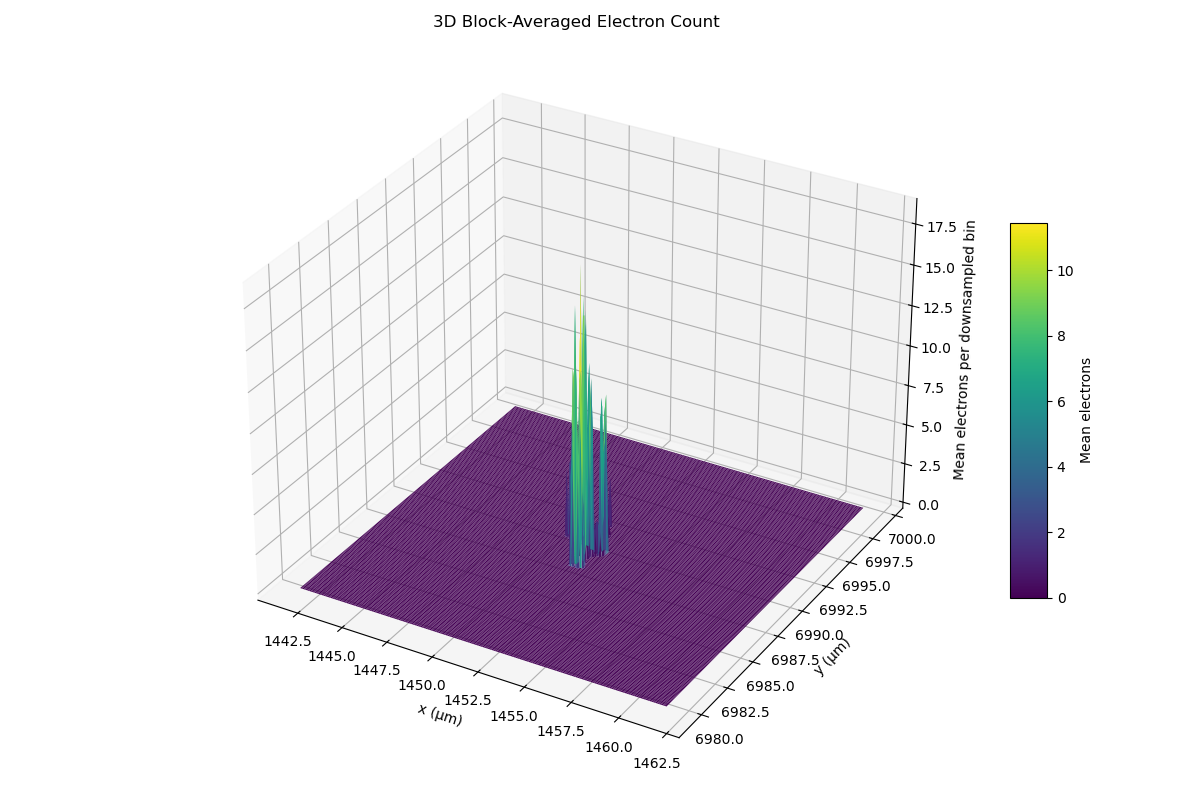

In [4]:
# Downsample with block averaging
downsample = 10
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()


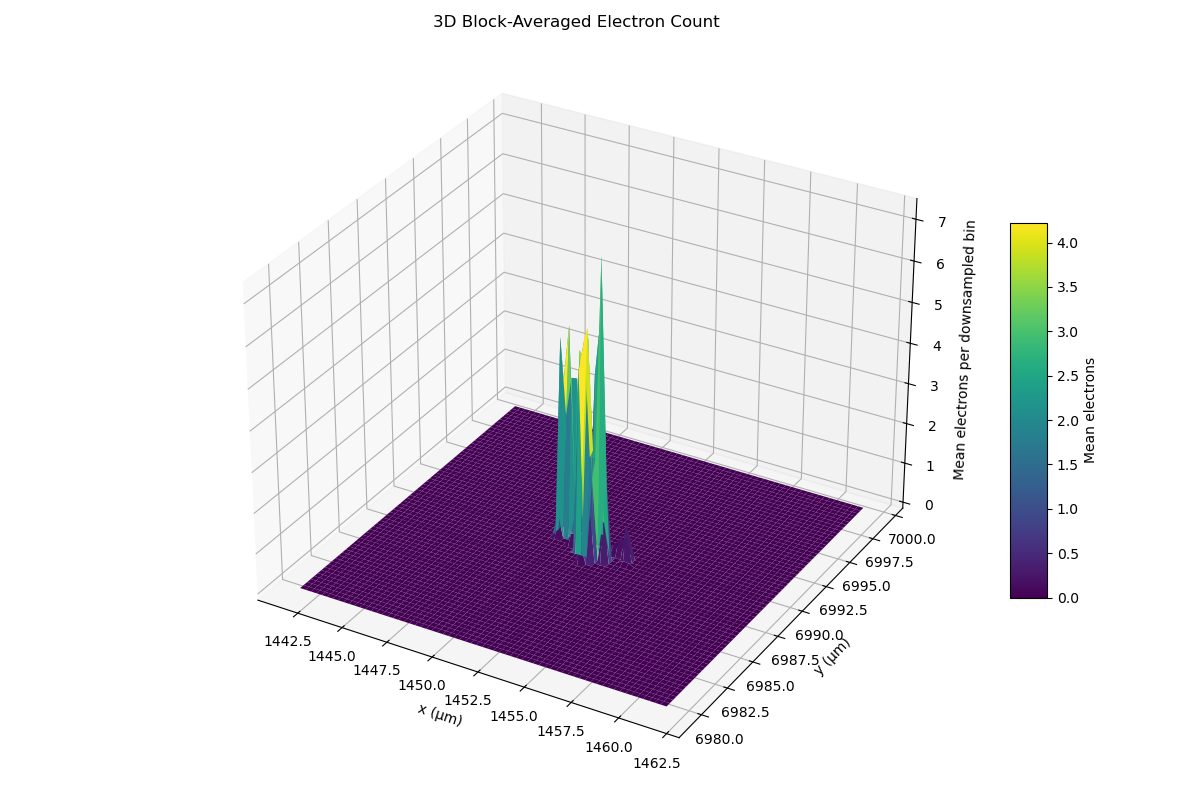

In [5]:
# Downsample with block averaging
downsample = 30
H3d = block_average(H, downsample)
nbins_x, nbins_y = H3d.shape

x = np.linspace(x_min, x_max, nbins_x)
y = np.linspace(y_min, y_max, nbins_y)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, H3d.T, cmap='viridis', edgecolor='none', rstride=1, cstride=1, antialiased=True)
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
ax.set_zlabel('Mean electrons per downsampled bin')
ax.set_title('3D Block-Averaged Electron Count')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Mean electrons')
plt.tight_layout()
plt.show()


Background (median of dark): -0.12
Robust sigma (MAD from diff frame): 6.29


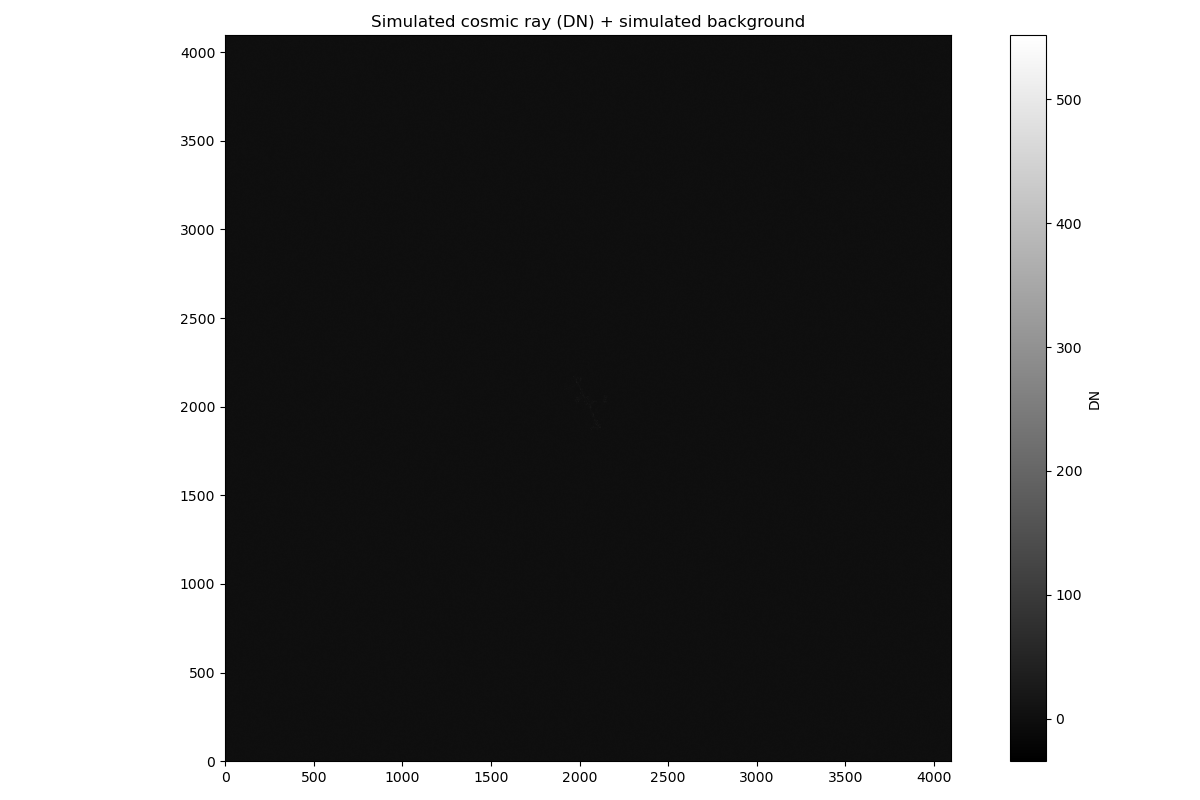

In [7]:
from pathlib import Path
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

try:
    here = Path(__file__).parent
except NameError:
    here = Path.cwd()

# --- Load single difference frame for noise estimate ---
diff_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'
with fits.open(diff_path) as hdulist:
    diff_data = hdulist[0].data
    if diff_data.ndim == 3:
        diff_data = diff_data[0]

# --- Load flat field and dark data ---
flat_path = here / 'cflat-20663.fits'
with fits.open(flat_path) as hdulist:
    flat_data = hdulist[0].data.astype(float)

dark_path = here / 'dark-20663.fits'
with fits.open(dark_path) as hdulist:
    dark_data = hdulist[0].data.astype(float)

# --- Normalize flat by median (robust gain map) ---
flat_norm = flat_data / np.nanmedian(flat_data)

# --- Median background from dark ---
background_median = np.nanmedian(dark_data)
# --- Robust noise estimate from difference frame using MAD ---
mad = median_abs_deviation(diff_data, scale='normal', nan_policy='omit', axis=None)
# For diff frames (difference of two frames), divide by sqrt(2) for single-frame equivalent
robust_sigma = mad / np.sqrt(2)
print(f"Background (median of dark): {background_median:.2f}")
print(f"Robust sigma (MAD from diff frame): {robust_sigma:.2f}")

ny, nx = H.shape
N, M = flat_norm.shape
H_padded = np.zeros((N, M), dtype=H.dtype)
start_y = (N - ny) // 2
start_x = (M - nx) // 2
H_padded[start_y:start_y+ny, start_x:start_x+nx] = H

# 1. Expand gain map to match full detector size
gain_array = np.loadtxt('Select_20663X_summary.txt')[:, 5].reshape((32, 32))
supercell_size = 128  # pixels per supercell

# Use np.kron to expand the gain map (repeats each value as a block of 128x128 pixels)
gain_map = np.kron(gain_array, np.ones((supercell_size, supercell_size)))

# Check the shape matches your detector (should be 4096x4096)
assert gain_map.shape == flat_norm.shape, f"Gain map shape {gain_map.shape} does not match detector shape {flat_norm.shape}"

# 2. Convert simulated electrons to DNs (avoid divide by zero)
gain_map_safe = np.where(gain_map > 0, gain_map, np.nan)  # or set to 1 to avoid nan/inf
H_DN = H_padded / gain_map_safe

# 3. Simulate background and noise (background and noise are already in DN if real flats/darks/diffs are in DN)
rng = np.random.default_rng()
sim_with_bg = H_DN + background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)

# 4. Plot
plt.figure(figsize=(12, 8))
plt.title("Simulated cosmic ray (DN) + simulated background")
plt.imshow(sim_with_bg,origin="lower", cmap='gray')
plt.colorbar(label='DN')
plt.tight_layout()
plt.show()

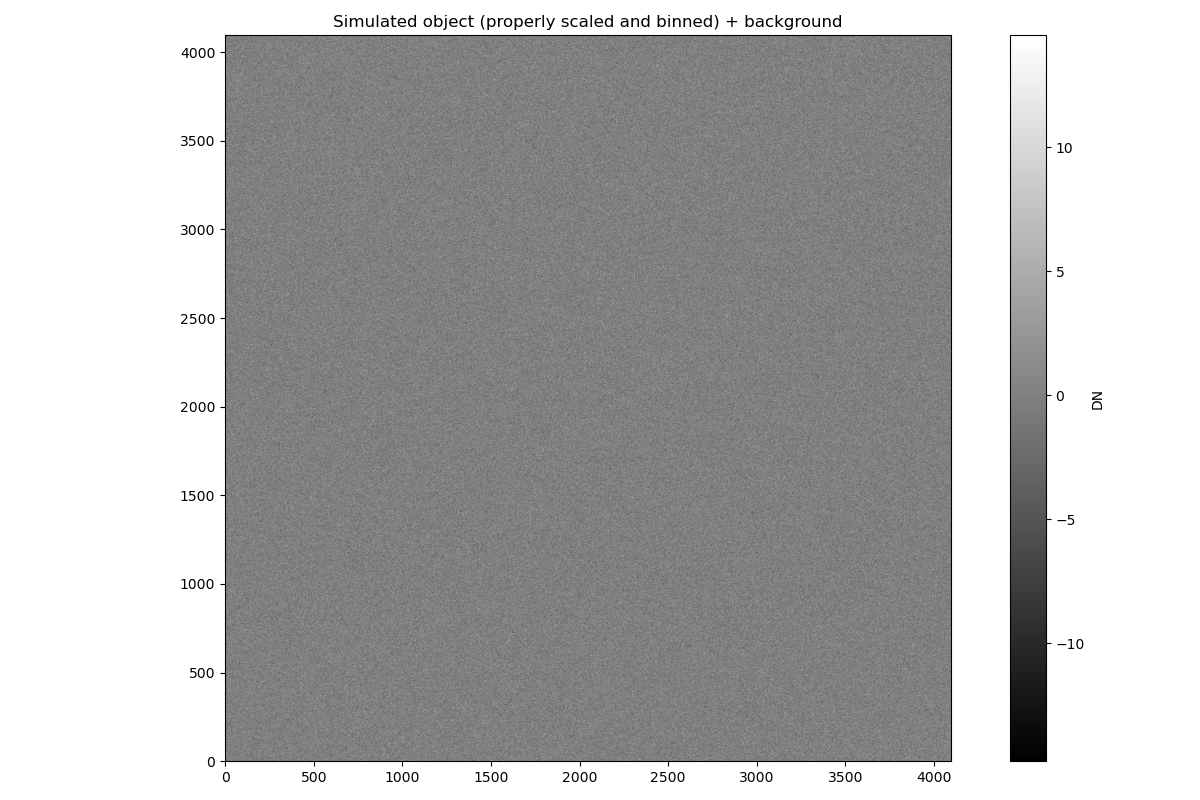

In [8]:
pixel_size = 10.0  # µm
det_pixels = 4096
det_size_um = det_pixels * pixel_size

# Bin simulated electrons onto the full detector pixel grid
# (all values in [0, det_size_um])
H_object_full = np.histogram2d(
    x_events, y_events,
    bins=[det_pixels, det_pixels],
    range=[[0, det_size_um], [0, det_size_um]]
)[0]  # [0] is the histogram counts, i.e. electrons per pixel

# Now H_object_full.shape == (4096, 4096), aligned with your flats, darks, and gain map
H_object_DN = H_object_full / gain_map_safe

sim_with_bg = H_object_DN + background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)
plt.figure(figsize=(12, 8))
plt.title("Simulated object (properly scaled and binned) + background")
plt.imshow(sim_with_bg, origin='lower', cmap='gray', vmin=np.percentile(sim_with_bg, 1), vmax=np.percentile(sim_with_bg, 99))
plt.colorbar(label='DN')
plt.tight_layout()
plt.show()


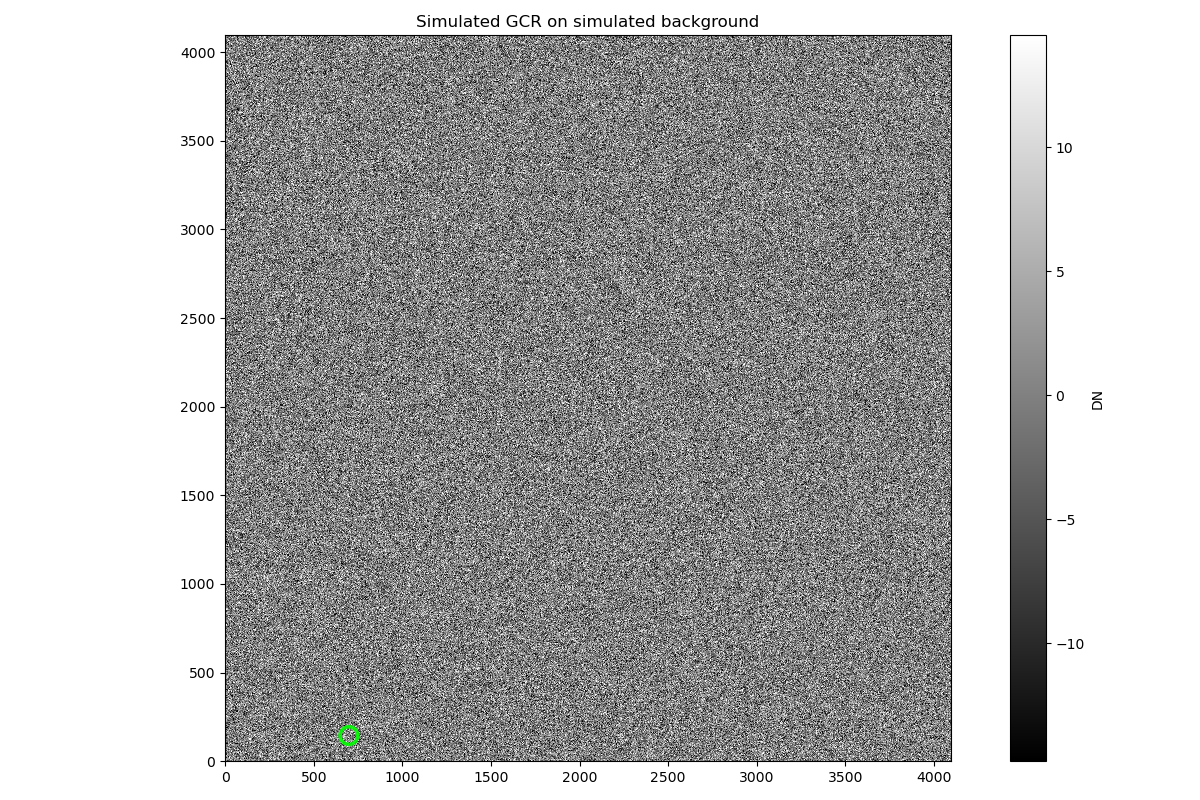

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# 1. Compute centroid or bounding box of object
yy, xx = np.nonzero(H_object_DN)
if len(xx) == 0:
    print("No object found in simulation!")
else:
    centroid_x = np.mean(xx)
    centroid_y = np.mean(yy)
    # Option: Compute the object's spatial extent
    radius = max(
        np.max(np.abs(xx - centroid_x)),
        np.max(np.abs(yy - centroid_y)),
        30  # minimum radius, in pixels
    ) + 20  # add a small margin

    # 2. Prepare overlay as before
    object_mask = H_object_DN > 0
    overlay = np.zeros((*H_object_DN.shape, 4))
    overlay[..., 0] = 1.0  # Red
    overlay[..., 3] = object_mask * 0.7

    # 3. Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Simulated GCR on simulated background")

    im = ax.imshow(sim_with_bg, origin='lower',  cmap='gray',
                   vmin=np.percentile(sim_with_bg, 1),
                   vmax=np.percentile(sim_with_bg, 99),
                   interpolation='nearest')
    ax.imshow(overlay, origin='lower', interpolation='nearest')

    # 4. Draw green circle around object
    circle = Circle((centroid_x, centroid_y), radius, 
                    color='lime', fill=False, linewidth=2.5, alpha=0.9)
    ax.add_patch(circle)

    plt.colorbar(im, ax=ax, label='DN')
    plt.tight_layout()
    plt.show()


In [12]:
# Reconstruct the "background only" image (without the object)
background_only = background_median * flat_norm + rng.normal(0, robust_sigma, size=flat_norm.shape)

# Compute the difference image (sim_with_bg - background)
delta_DN = sim_with_bg - background_only

# Create a mask of where the simulated object landed
object_mask = H_object_DN > 0

# Extract DN changes in those pixels
changed_DNs = delta_DN[object_mask]

print(f"Number of pixels affected: {object_mask.sum()}")
print("DN change in those pixels:", changed_DNs)
print(f"Mean DN change: {np.mean(changed_DNs):.2f} | Max: {np.max(changed_DNs):.2f} | Min: {np.min(changed_DNs):.2f}")

# show pixel coordinates and DN change
yy, xx = np.nonzero(object_mask)
for x, y, dn in zip(xx, yy, changed_DNs):
    print(f"Pixel ({x},{y}): ΔDN = {dn:.2f}")


Number of pixels affected: 3
DN change in those pixels: [  3.01878648 191.08693771  28.39122415]
Mean DN change: 74.17 | Max: 191.09 | Min: 3.02
Pixel (698,144): ΔDN = 3.02
Pixel (698,145): ΔDN = 191.09
Pixel (699,145): ΔDN = 28.39
